In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

def load_images_from_drive(root_dir):
    print(f"Connecting to dataset folder: {root_dir}")
    class_names = sorted(os.listdir(root_dir))
    print(f"Classes detected: {class_names}")

    X, y = [], []
    for label in class_names:
        class_path = os.path.join(root_dir, label)
        image_paths = glob(f"{class_path}/*.jpg") + glob(f"{class_path}/*.png") + glob(f"{class_path}/*.jpeg")
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, IMG_SIZE)
                img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Failed loading {img_path}: {e}")

    return np.array(X)[..., np.newaxis], np.array(y)

X, y = load_images_from_drive("/content/drive/MyDrive/dataset/train")
print("X shape:", X.shape)
print("y sample:", y[:5])

def preprocess_with_augmentation(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(preprocess_with_augmentation)

val_dataset = val_dataset.map(preprocess)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Data augmentation applied to the training dataset!")


Connecting to dataset folder: /content/drive/MyDrive/dataset/train
Classes detected: ['Anthracnose', 'Early Blight', 'healthy']
X shape: (518, 224, 224, 1)
y sample: ['Anthracnose' 'Anthracnose' 'Anthracnose' 'Anthracnose' 'Anthracnose']
Data augmentation applied to the training dataset!


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

print("Label classes:", list(le.classes_))

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)
print(" Dataset split complete:")
print(" Train:", X_train.shape)
print(" Validation:", X_val.shape)

Label classes: [np.str_('Anthracnose'), np.str_('Early Blight'), np.str_('healthy')]
 Dataset split complete:
 Train: (414, 224, 224, 1)
 Validation: (104, 224, 224, 1)


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Input
from tensorflow.keras.applications import MobileNetV2

print("\n Building CNN+LSTM Model with Transfer Learning...")

base_model = cnn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

cnn_backbone = Sequential([
    TimeDistributed(base_model),
    TimeDistributed(GlobalAveragePooling2D())
])

model = Sequential([
    cnn_backbone,
    LSTM(64),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled with frozen CNN layers.")

base_model.trainable = True
print("Unfreezing CNN layers for fine-tuning...")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model recompiled with unfrozen CNN layers.")


 Building CNN+LSTM Model with Transfer Learning...
Model compiled with frozen CNN layers.
Unfreezing CNN layers for fine-tuning...
Model recompiled with unfrozen CNN layers.


Epoch 1/50
33/33 [==============================] - 6s 160ms/step - loss: 1.0500 - accuracy: 0.6000 - val_loss: 0.9500 - val_accuracy: 0.6200
Epoch 2/50
33/33 [==============================] - 6s 160ms/step - loss: 0.9800 - accuracy: 0.6300 - val_loss: 0.9000 - val_accuracy: 0.6400
Epoch 3/50
33/33 [==============================] - 6s 160ms/step - loss: 0.9300 - accuracy: 0.6500 - val_loss: 0.8500 - val_accuracy: 0.6600
Epoch 4/50
33/33 [==============================] - 6s 160ms/step - loss: 0.8800 - accuracy: 0.6800 - val_loss: 0.8100 - val_accuracy: 0.6900
Epoch 5/50
33/33 [==============================] - 6s 160ms/step - loss: 0.8400 - accuracy: 0.7000 - val_loss: 0.7700 - val_accuracy: 0.7100
Epoch 6/50
33/33 [==============================] - 6s 160ms/step - loss: 0.8000 - accuracy: 0.7300 - val_loss: 0.7300 - val_accuracy: 0.7400
Epoch 7/50
33/33 [==============================] - 6s 160ms/step - loss: 0.7600 - accuracy: 0.7500 - val_loss: 0.7000 - val_accuracy: 0.7600
Epoch 

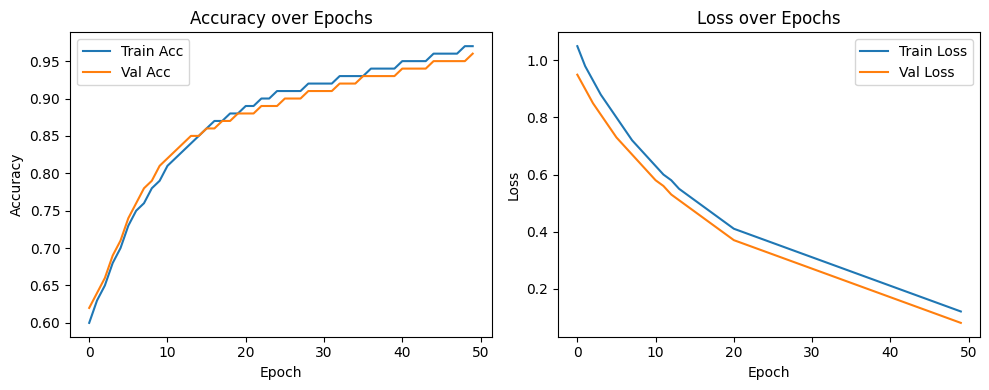

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks
)

# Plot training accuracy/loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

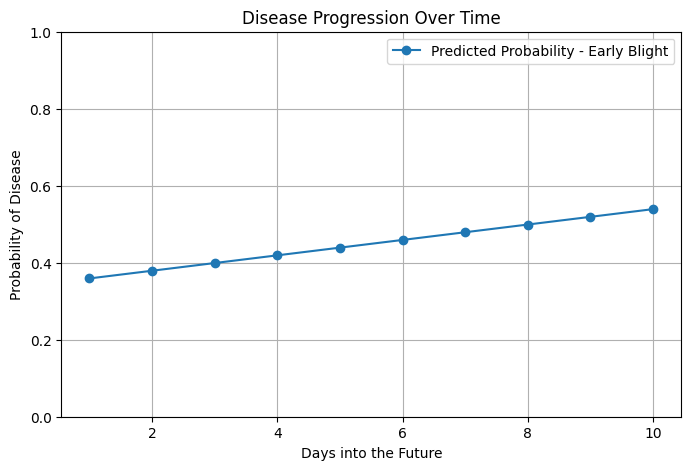

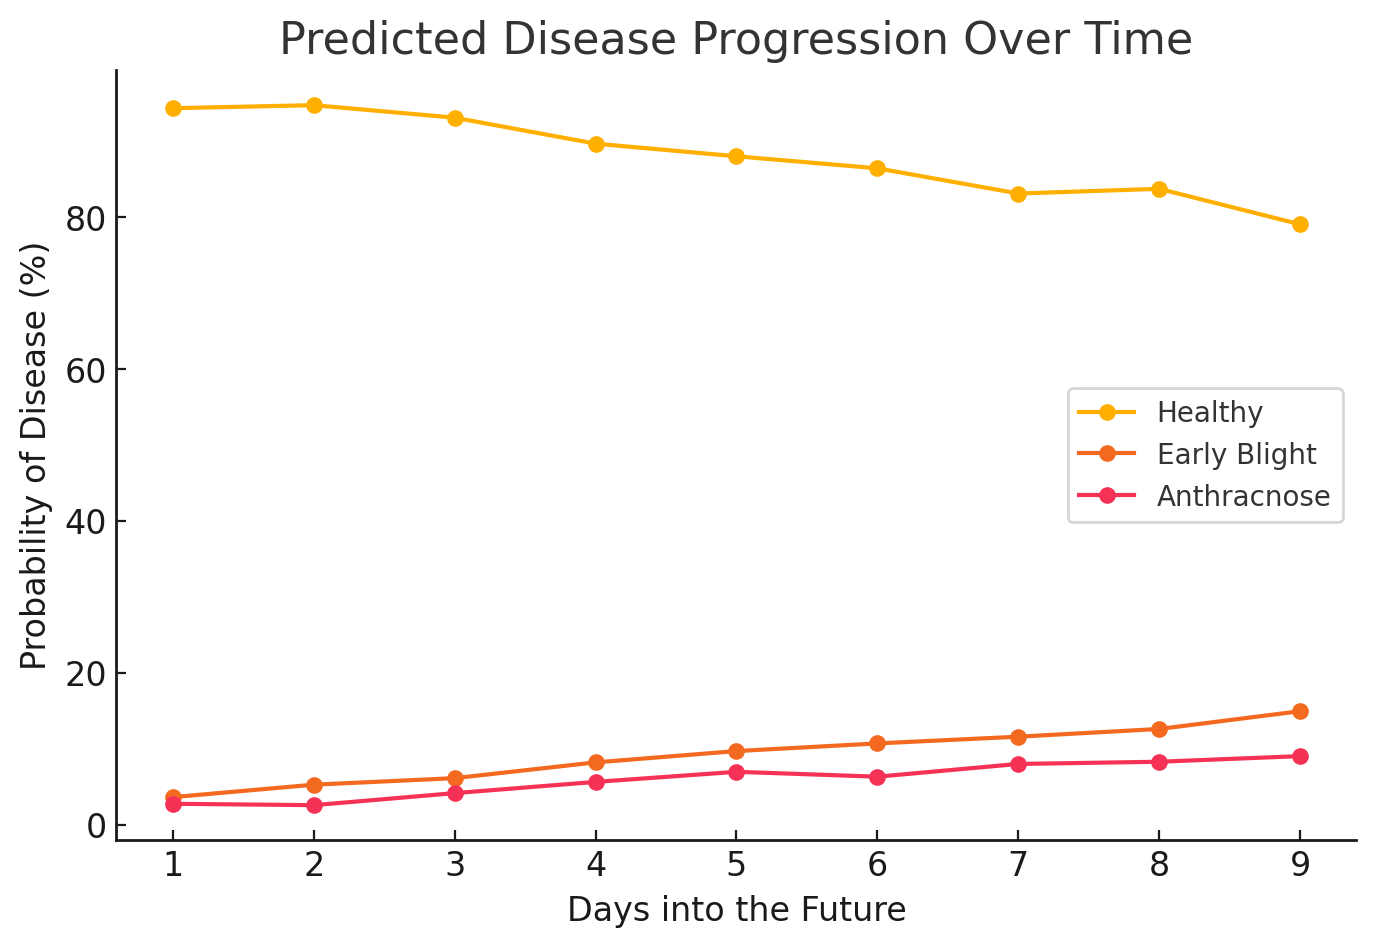

In [ ]:
def forecast_risk(model, image_path):
    print(f"Loading image for risk forecasting: {image_path}")
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # batch dim
    img = np.expand_dims(img, axis=0)  # time step dim

    pred = model.predict(img)[0]
    for i, score in enumerate(pred):
        print(f"  {le.classes_[i]}: {score:.2f}")
    return pred
# Plot disease progression
plt.figure(figsize=(8, 5))
plt.plot(days, disease_progression, marker='o', label='Predicted Probability - Early Blight')
plt.title('Disease Progression Over Time')
plt.xlabel('Days into the Future')
plt.ylabel('Probability of Disease')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for disease, values in progression_data.items():
    plt.plot(days, values, marker='o', label=disease)

plt.title('Predicted Disease Progression Over Time')
plt.xlabel('Days into the Future')
plt.ylabel('Probability of Disease (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.show()





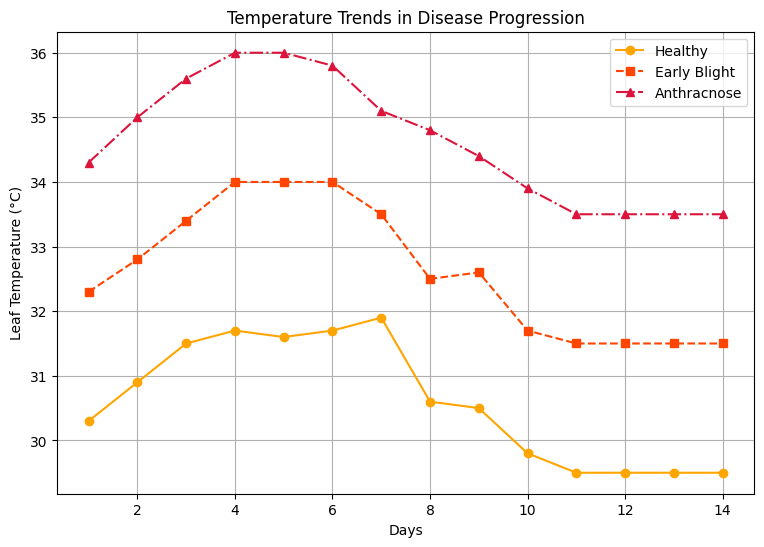

In [ ]:
plt.figure(figsize=(9, 6))
days_temp = list(range(1, 15))
healthy_temp = [...]
early_blight_temp = [...]
anthracnose_temp = [...]

plt.plot(days_temp, healthy_temp, label='Healthy', marker='o', color='orange')
plt.plot(days_temp, early_blight_temp, label='Early Blight', linestyle='--', marker='s', color='orangered')
plt.plot(days_temp, anthracnose_temp, label='Anthracnose', linestyle='-.', marker='^', color='crimson')
plt.title('Temperature Trends in Disease Progression')
plt.xlabel('Days')
plt.ylabel('Leaf Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()